# Working with Multielectrode Data in pandas

If you haven't already, please read the [description](./intro_multielec_data) of the experiment that this data comes from, in the previous section.

We're going to load in the multielectrode array data from a CSV file, do some EDA, and make some inferences with respect to our experimental questions. 

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Set known experiment parameters

In [2]:
# times the stimulus went on and off
trial_start_time = -0.150
grating_on_time  = 0.0
grating_off_time = 2.0
trial_end_time   = 2.5

## Import the data


In [3]:
df = pd.read_csv('data/multielectrode_data.csv')

### Exploring the data 


These data are again in **long format**, and they are sparse data with one row for each spike. Let's look at the head of the data to get oriented:

In [4]:
df.head()

,channel,time,orientation,trial
0,42.0,2.425,90.0,0.0
1,42.0,2.452,90.0,0.0
2,42.0,2.483,90.0,0.0
3,42.0,2.515,90.0,0.0
4,42.0,2.545,90.0,0.0


The columns are:
- channel — which electrode the data came from
- time — spike time, relative to stimulus onset (so we have negative values for spikes that occurred during the fixation period prior to stimulus onset). This is measured in seconds
- orientation — of stimulus (0 or 90 deg)
- trial number — 1150 trials for each orientation

We can see how many rows there are in the DataFrame (as well as the number of columns, but we could already see that in this case):

In [5]:
df.shape

(623406, 4)

### Electrodes
Let's see how many electrodes we have data from, and what their labels are. We save each as a variable, which will come in handy later in looping through these.

In [6]:
num_chan = len(df['channel'].unique())
print('Number of electrodes (channels): ' + str(num_chan))

channels = sorted(df['channel'].unique())  # use the sorted() function so the channels are listed sequentially
print('Channel labels: ' + str(channels))

Number of electrodes (channels): 20
Channel labels: [4.0, 7.0, 10.0, 22.0, 23.0, 32.0, 35.0, 42.0, 44.0, 45.0, 63.0, 67.0, 73.0, 75.0, 79.0, 80.0, 86.0, 91.0, 95.0, 96.0]


This is a bit weird — we're told this is a 96 electrode array, but there are only 20 electrodes?!  

This is because the full data set is huge, with over 2 million rows. The amount of memory that this requires makes doing anything with the data quite slow. So we've provided data from a subset of channels for the purposes of this tutorial.

### Orientations
What about orientations?

In [7]:
orientations = sorted(df['orientation'].unique())
num_ortns = len(orientations)
print('Found ' + str(num_ortns) + ' orientations, which are: ' + str(orientations))

Found 2 orientations, which are: [0.0, 90.0]


---
## Peri-Stimulus Time Histograms (PSTH)

Since we have thousands of trials, we're not going to plot rasters for this data set. Since PSTHs collapse across trials, this is a more convenient and compact way of representing spiking activity as a function of time. 

Let's start by extracting the data for one channel, #4:

In [8]:
dat = df[(df['channel'] == 4)]

We'll use pandas' `.hist()` method to obtain a PSTH, firstly just across all trials and electrodes/neurons, with the following arguments:
- `column='time'` cspecifies that the values in this column (spike times) are used to generate the histogram
- the `by='orientation'` argument generates separate plots for each value in the orientation column
- the `bins=time_bins` variable we set earlier defines the x axis of the histogram (`bins`); `time_bins` is in 10 ms increments so that becomes the size of our histogram bins
- `sharey` forces the y axis range to be the same across plots
- `layout` specifies 2 rows (each orientation) and one column
- `figsize` was determined by trial and error to provide a subjectively-nice aspect ratio and fit the figure in the notebook

### Define bin widths
One thing we need to do before creating any histograms is defining our bin widths. Although the histogram function will do this automatically, for PSTHs we want more control over the bins, specifically so that each bin corresponds to a 10 ms period. 

Recall that the spike times are in seconds, so we use 0.01 as the step size to get 10 ms bins, going from the start to the end of the trial. 

In [9]:
# Create a set of 10 ms bins for our PSTHs, spanning the time range of each trial
time_bins = np.arange(trial_start_time, trial_end_time, 0.01)

### Plot the PSTH

Since the independent variable in this experiment was the orientation of the stimulus, we'll plot PSTHs for each orientation separately.

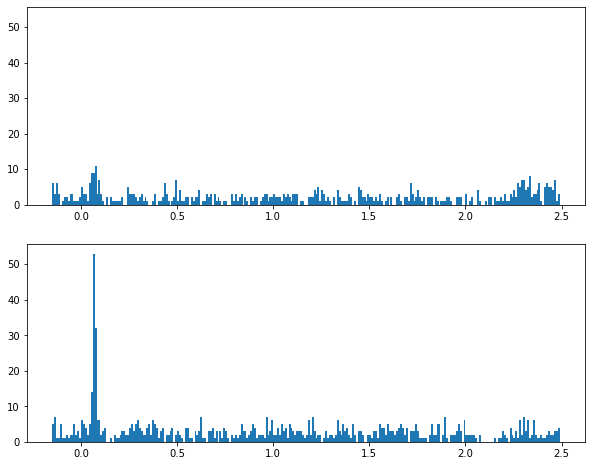

In [10]:
fig, axs = plt.subplots(2, 1, figsize=[10, 8], sharey=True)

for idx, ori in enumerate(orientations):
    axs[idx].hist(dat[dat['orientation'] == ori]['time'], 
                 bins=time_bins)

plt.show()

### Plot both orientations overlaid

For this we use the kwarg `histtype='step'` to draw the histograms as lines rather than bars:

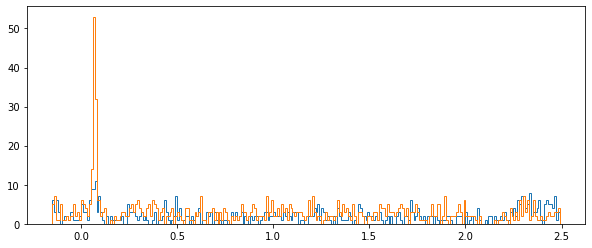

In [11]:
fig, axs = plt.subplots(figsize=[10, 4], sharey=True)

for idx, ori in enumerate(orientations):
    axs.hist(dat[dat['orientation'] == ori]['time'], 
                  bins=time_bins,
                  histtype='step' 
                 )
    

plt.show()

## Make array of histograms

The above examples were OK for one channel, but it would be nice to have more control over the plots and be able to easily work with all of the data at once. 

To facilitate this, we'll make a NumPy array of histograms similar to what we did in the heat maps lesson. However, in this case the rows of the array are not intensity levels, but each combination of channel and orientation. We're not going to use this array to plot heat maps (since the rows here aren't levels of a continuous variable), but just to store the histograms to make it easy to plot them later.

After we make the NumPy array we convert it into a pandas DataFrame, which allows us to make the column labels the actual time points that each bin starts with.

In [60]:
df_list = []

# Initialize hitogram array
# bins are edges, so there is 1 less value in histogram than in bins
hist_arr = np.zeros([num_chan * num_ortns, 
                     len(time_bins)-1]  
                   )

# initialize row index variable to increase each time through the loop
r_idx = 0

for chan in channels:
    for ori in orientations:
        hist_arr[r_idx], bins = np.histogram(df[(df['channel']==chan) & (df['orientation']==ori)]['time'],
                                             bins=time_bins)
        r_idx += 1 # increment counter for next row
        
# Convert to pandas DataFrame with time values as column labels   
# We'll round the time values so that they don't have reallly long decimal places
df_psth = pd.DataFrame(hist_arr,
                      columns=np.round(time_bins[:-1], 3))        

In [61]:
df_psth.head()

,-0.15,-0.14,-0.13,-0.12,-0.11,-0.10,-0.09,-0.08,-0.07,-0.06,...,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48
0,6.0,3.0,6.0,3.0,0.0,1.0,2.0,2.0,1.0,3.0,...,1.0,0.0,5.0,6.0,5.0,5.0,4.0,7.0,1.0,3.0
1,5.0,7.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,3.0,4.0
2,7.0,7.0,8.0,10.0,6.0,5.0,3.0,3.0,1.0,1.0,...,1.0,2.0,5.0,4.0,1.0,1.0,1.0,2.0,4.0,5.0
3,9.0,7.0,7.0,9.0,4.0,4.0,3.0,4.0,2.0,3.0,...,0.0,2.0,1.0,3.0,5.0,3.0,3.0,7.0,1.0,5.0
4,21.0,29.0,24.0,18.0,13.0,7.0,7.0,7.0,3.0,9.0,...,11.0,17.0,9.0,7.0,14.0,12.0,15.0,15.0,11.0,11.0


### Create columns of labels
Next we'll add columns for channel and orientation labels.

To make this DataFrame, first we'll create a DataFrame of the two columns of labels we want (channel and orientation) and then we'll concatenate that with the NumPy array. 

In [62]:
labels_tmp = []

for chan in channels:
    for ori in orientations:
        labels_tmp.append([chan, ori])
        
condition_labels = pd.DataFrame(labels_tmp, 
                                columns=['channel', 'orientation'])

condition_labels.head(8)

,channel,orientation
0,4.0,0.0
1,4.0,90.0
2,7.0,0.0
3,7.0,90.0
4,10.0,0.0
5,10.0,90.0
6,22.0,0.0
7,22.0,90.0


Then we can merge the labels and histograms with `pd.concat()`. The first argument to `pd.concat()` is a list of the DataFrames you want to merge, and the `axis=1` kwarg is used to specify that we want to merge by columns (add the two DataFrames side-by-side, instead of one on top of the other).

Note that we don't assign the output to a new variable, we just view the head, because we're actually going to make the final version of this DataFrame a different way below.

In [63]:
pd.concat([condition_labels, df_psth], axis=1).head()

,channel,orientation,-0.15,-0.14,-0.13,-0.12,-0.11,-0.1,-0.09,-0.08,...,2.39,2.4,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48
0,4.0,0.0,6.0,3.0,6.0,3.0,0.0,1.0,2.0,2.0,...,1.0,0.0,5.0,6.0,5.0,5.0,4.0,7.0,1.0,3.0
1,4.0,90.0,5.0,7.0,1.0,1.0,5.0,1.0,1.0,2.0,...,2.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,3.0,4.0
2,7.0,0.0,7.0,7.0,8.0,10.0,6.0,5.0,3.0,3.0,...,1.0,2.0,5.0,4.0,1.0,1.0,1.0,2.0,4.0,5.0
3,7.0,90.0,9.0,7.0,7.0,9.0,4.0,4.0,3.0,4.0,...,0.0,2.0,1.0,3.0,5.0,3.0,3.0,7.0,1.0,5.0
4,10.0,0.0,21.0,29.0,24.0,18.0,13.0,7.0,7.0,7.0,...,11.0,17.0,9.0,7.0,14.0,12.0,15.0,15.0,11.0,11.0


### Advanced approach: Using list comprehension

The above steps work fine, but gust for fun, here's a tricky but elegant *nested list comprehension* way of doing this. Recall that a list comprehension is essentially a `for` loop inside a set of square brackets, that creates a list. But just as we can nest one `for` loop inside another, we can nest `for` statements inside list comprehensions, to create a list of lists, and then convert that to a pandas DataFrame, all in one line of code.

In [64]:
condition_labels = pd.DataFrame([[chan, ori] for chan in channels for ori in orientations ],
                               columns=['channel', 'orientation'])

condition_labels.head(8)

,channel,orientation
0,4.0,0.0
1,4.0,90.0
2,7.0,0.0
3,7.0,90.0
4,10.0,0.0
5,10.0,90.0
6,22.0,0.0
7,22.0,90.0


#### Add labels to histograms DataFrame with list comprehension

The cool thing about the list comprehension approach is that we don't need to separately make a DataFrame of labels and then merge that with the DataFrame of histograms; instead, we can just pass the list comprehension as two new channels of the DataFrame, all in one step. 

This works because the list comprehension runs in a single line of code, and because pandas will interpret each entry in a list of list as a row in a DataFrame. We just have to be sure to assign the results of the list comprehension to a list of column labels. That is, below we use 

    df_psth[['channel', 'orientation']]

and not 

    df_psth['channel', 'orientation']


In [65]:
df_psth[['channel', 'orientation']] = [[chan, ori] for chan in channels for ori in orientations]

Finally, since we have wide-format data here, and the two columns we just added are labels, we will make these two columns indexes of the DataFrame. This will make working with it easier later on.

In [66]:
df_psth = df_psth.set_index(['channel', 'orientation'])

df_psth.head()

-0.15  -0.14  -0.13  -0.12  -0.11  -0.10  -0.09  -0.08  \
channel orientation                                                           
4.0     0.0            6.0    3.0    6.0    3.0    0.0    1.0    2.0    2.0   
        90.0           5.0    7.0    1.0    1.0    5.0    1.0    1.0    2.0   
7.0     0.0            7.0    7.0    8.0   10.0    6.0    5.0    3.0    3.0   
        90.0           9.0    7.0    7.0    9.0    4.0    4.0    3.0    4.0   
10.0    0.0           21.0   29.0   24.0   18.0   13.0    7.0    7.0    7.0   

                     -0.07  -0.06  ...   2.39   2.40   2.41   2.42   2.43  \
channel orientation                ...                                      
4.0     0.0            1.0    3.0  ...    1.0    0.0    5.0    6.0    5.0   
        90.0           1.0    2.0  ...    2.0    1.0    1.0    2.0    3.0   
7.0     0.0            1.0    1.0  ...    1.0    2.0    5.0    4.0    1.0   
        90.0           2.0    3.0  ...    0.0    2.0    1.0    3.0    5.0   
10.0    0.0            3.0    9.0  ...   11.0   17.0    9.0    7.0   14.0   

                      2.44   2.45   2.46   2.47   2.48  
channel orientation                                     
4.0     0.0            5.0    4.0    7.0    1.0    3.0  
        90.0           2.0    2.0    3.0    3.0    4.0  
7.0     0.0            1.0    1.0    2.0    4.0    5.0  
        90.0           3.0    3.0    7.0    1.0    5.0  
10.0    0.0           12.0   15.0   15.0   11.0   11.0  

[5 rows x 264 columns]

### Plotting the Histograms

Now we can plot the histograms that we just completed. These should look similar to the panel of 8 histograms we plotted above; the big difference is that above we use pandas `.histogram()` method, whereas here we pre-computed the histograms so that we can use Matplotlib's more flexible and general-purpose `.plot()` function. This allows us more control and power in drawing the plot. For example, below we shade in the time period when the stimulus was on, and we draw the PSTHs as lines rather than bars. Although this may seem like something of an aesthetic preference, as you'll see below, lines give you the ability to overlay PSTHs for different conditions, allowing comparison.

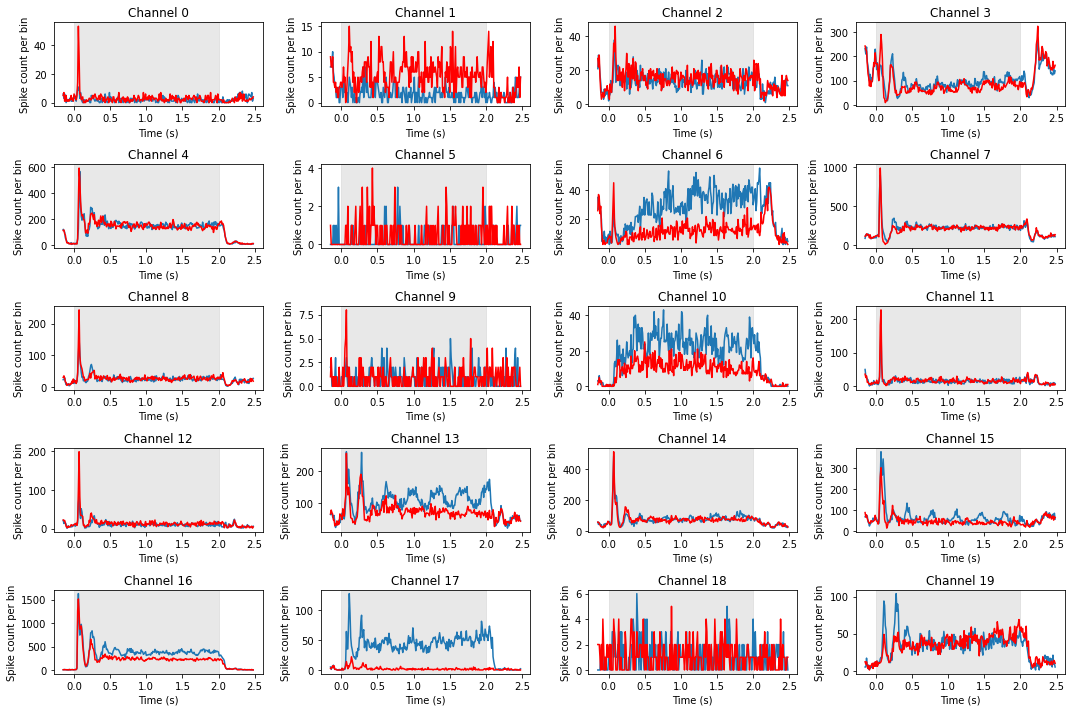

In [77]:
# We know there are 20 channels so define a 5 x 4 array of subplots
fig, axs = plt.subplots(5, 4, figsize=[15, 10])

# Use enumerate to loop through channels
for chan, ax in enumerate(axs.reshape(-1)):
    # 0 deg orienation
    ax.plot(time_bins[:-1], 
           df_psth.loc[(channels[chan], orientations[0])]
           )

    # 90 deg orientation
    ax.plot(time_bins[:-1], 
           df_psth.loc[(channels[chan], orientations[1])],
           color='red'
           )

    ax.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    ax.set_title('Channel ' + str(chan))
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
        

plt.tight_layout() 
plt.show()    

Note above the differences in total spike counts (*y* axis ranges) between channels. In this case we haven't normalized the spike counts, so each subplot is scaled to the range of values for that channel. Generally speaking, this is fine, because we are primarily interested in the shapes of the PSTHs over time. However, note that the channels that appear particularly noisy (e.g., channels 0, 5, 9, and 18) all have maximum *y* axis values of well under 20 spikes, whereas the scale on most other channels is in the hundreds or thousands. This suggests these channels are not really noisy, but have very low firing rates and likely do not reflect the activity of neurons.

## Interpreting the data

If you examine the set of PSTHs above, you will see than a number of channels show very similar patterns, with a transient spike in firing rate immediately after stimulus onset, followed by a plateau. However, even among the neurons that show a strong initial response, there are different patterns. Some, like 1 and 12, show a return to baseline after the initial spike. This is a classic response pattern of neurons in primary visual cortex (V1). In contrast others, like 4 and 7, show a sustained level of firing as long as the stimulus is on, and then a decrease to baseline after it turns off. Another difference is between channels that show "transients" (brief oscillations) after the initial spike (e.g., 4, 8, 12, and particularly 16) and those that do not (e.g., 0, 11). 

 A couple of channels (13, 17, 10, 15) show oscillations in firing rates over the entire duration of the stimulus. Across the entire array of 96 neurons, we could potentially identify different subtypes of neurons based on these different response patterns.

Most relevant to the present experiment though, was the manipulation of stimulus orientation. We can see that only a few channels show a clear difference in firing rate between the two orientations. Most notably are 13, 17, 6, and 10, but 15 also shows an interesting pattern whereby the 0 deg orientation (blue) evokes an oscillation for the duration of the stimulus that the 90 deg stimulus does not. 

A number of different analysis approaches could be applied to the data at this point. For example, we could use a statistical test to determine whether the difference in firing rate between the two orientations is significant at each channel, and over what time interval(s). We could also use a clustering algorithm to identify subtypes of neurons based on their response patterns. We could also use a dimensionality reduction technique to identify the main dimensions of variation in the data. We will not pursue these analyses in detail, but in the next section we will look at one important step towards analyzing multi-channel data, which is identifying relationships between different channels in the array.